In [1]:
# step 8
from mne.time_frequency import tfr_morlet
from alive_progress import alive_bar
import matplotlib.pyplot as plt
from tqdm import tqdm
import nibabel as nib
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import h5py
import mne
import sys
import os
import mantel

subject_num = 34
var_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/result/varibilit_corr_20/'
# eegVar_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/result/varibilit_corr_20_exp2_new_all_step_corr/all_var_data_one_all_6band.npy'
result_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/result/corr_exp1_exp2/'
# plot_loc = result_loc + 'plot_result_untrust/'

experiment_2_event = [1, 2, 3, 4]
experiment_3_event = [30, 31, 32, 33]
experiment_4_event = [30, 31, 32, 33]
# file_name = ['ERP', 'delta', 'theta', 'alpha', 'beta', 'gamma']
# # file_name = ['delta_theta_alpha']
# power_name = ['delta', 'theta', 'alpha']
power_name = ['alpha']
condition_name = ['0Trust', '1Trust', '2Trust', '3Trust']


In [2]:

bad_subject = np.array([3, 5, 15]) -1
all_subject = np.arange(0,34,1)


good_subject = np.setdiff1d(all_subject, bad_subject)

In [3]:
# import the variation of exp1
eeg_varibility = np.load(var_loc + 'all_var_data_nor.npy', allow_pickle=True).item()

exp1_variability = eeg_varibility['data'][good_subject, 3, 0,]

print(exp1_variability.shape)

(34, 6, 3, 63, 1200)
dict_keys(['shape', 'power_band', 'event_name', 'ch_names', 'fs', 'data', 'tmin'])
['all_event', 'Trust', 'unTrust']
(31, 63, 1200)


In [4]:
# Import the variation of exp2 and exp3 
result2_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/result/varibilit_corr_20_exp2/'
result3_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/result/varibilit_corr_20_exp3/'
all_var_result2 = np.load(result2_loc +'/' + 'face_alpha_var_nor_result.npy', allow_pickle=True).item()
all_var_result3 = np.load(result3_loc +'/' + 'face_alpha_var_nor_result.npy', allow_pickle=True).item()
print(all_var_result2['data'].shape)

# concatenate the data of Exp2 and Exp 3
all_var_result2_data = np.squeeze( all_var_result2['data'])
all_var_result3_data = np.squeeze(all_var_result3['data'])
print(all_var_result3_data.shape)
all_var_result23_data = np.concatenate((all_var_result2_data,all_var_result3_data),axis=2)
print(all_var_result23_data.shape)

(34, 1, 4, 5, 63, 1200)
(34, 4, 2, 63, 1200)
(34, 4, 7, 63, 1200)


In [30]:
# Devide 63 electrode to 6 regions
region_ch_list={}
region_ch_list[0] = ['FT9','Fp1', 'Fpz', 'AF7','F7','FT7','AF3','F5','F3','F1','Fz','FC1','FC3','FC5']
region_ch_list[1] = ['FT10', 'Fpz', 'Fz', 'FC2', 'FC4', 'FC6', 'FT8', 'F2', 'F4', 'F6', 'F8', 'AF4', 'AF8', 'Fp2']
region_ch_list[2] = ['TP9','FT9','FC1','FC3','FC5', 'FT7', 'Cz', 'CPz', 'CP1', 'CP3', 'CP5', 'TP7', 'T7', 'C5', 'C3', 'C1']
region_ch_list[3] = ['TP10','FT10', 'FC2', 'FC4', 'FC6', 'FT8', 'Cz', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'T8', 'C6', 'C4', 'C2']
region_ch_list[4] = ['TP9','Oz', 'POz', 'Pz', 'CPz', 'CP1', 'CP3', 'CP5', 'TP7', 'P1', 'P3', 'P5', 'P7', 'PO3', 'PO7', 'O1']
region_ch_list[5] = ['TP10','Oz', 'POz', 'Pz', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8', 'O2']

ch_names = all_var_result2['ch_names']
region_ch_location={}

for iter_region in range(6):
    region_ch_location[iter_region]=[]
    for iter_channel in range(len(region_ch_list[iter_region])):
        iter_channel_position = np.where(np.array(ch_names) == region_ch_list[iter_region][iter_channel])[0][0]

        region_ch_location[iter_region].append(iter_channel_position)

# Map the data of 63 eectrodes to 6 regions (exp2&3)
region_all_var_result23_data = np.full((34,4,7,6,1200), np.nan)
for iter_region in range(6):
    region_all_var_result23_data[:,:,:,iter_region,:] = np.mean(all_var_result23_data[:,:,:,region_ch_location[iter_region],:],axis=3)
print(region_all_var_result23_data.shape)


# Map the data of 63 eectrodes to 6 regions (exp1)
region_exp1_data = np.full((31, 6,1200), np.nan)
for iter_region in range(6):
    region_exp1_data[:,iter_region] = np.mean(exp1_variability[:,region_ch_location[iter_region]],axis=1)
print(region_exp1_data.shape)


exp1_data = np.mean(region_exp1_data[:,:,200:500],axis=2) # 0-300ms
print(exp1_data.shape)

# calculate the temporal mean eeg variability 0-300ms
mean_region_all_var_result23_data = np.mean(region_all_var_result23_data[:,:,:,:,200:500],axis=-1)
print(mean_region_all_var_result23_data.shape)

exp2_data = np.mean(mean_region_all_var_result23_data[:,:,0:2],axis=2) # step 1 and 2
exp2_data = np.mean(exp2_data,axis=1)
print(exp2_data.shape)

exp2_data = exp2_data[good_subject]


(34, 4, 7, 6, 1200)
(31, 6, 1200)
(31, 6)
(34, 4, 7, 6)
(34, 6)


4.43882142964577e-07
1.1240623929222822e-05
2.388078060211873e-10
5.345582481815612e-08
6.584571407121187e-09
1.2163486255645392e-09


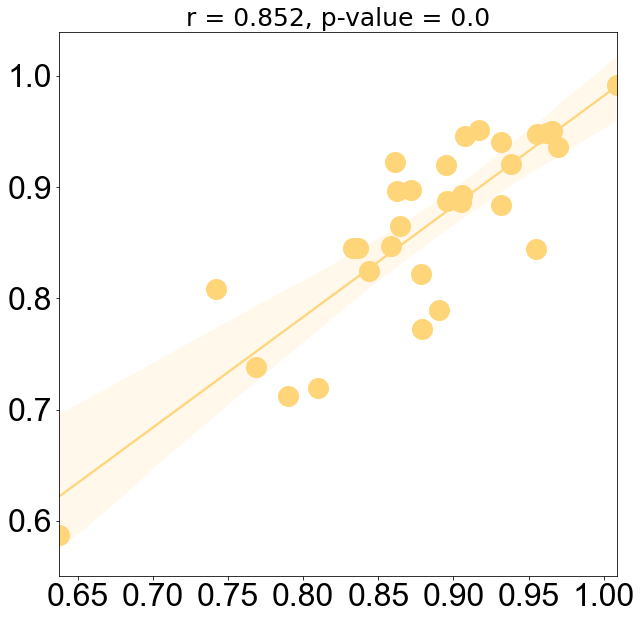

In [36]:
# Plot：Use the 1-3 mean EEG variability to predict the Exp2-3 behavior change. # mean_all_rsa_result23_0_300
# 设定画图的参数
import seaborn as sns
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from hm_tools import *
figsize=(10,10)
title_size=25
legend_size=15 
labelsize=23
ticksize=32
plot_loc = result_loc + '/var1_2_0_300/'
hm_make_dir(plot_loc)
event_name = ['trust0', 'trust1', 'trust2', 'trust3']
all_color = ['#70AD47', '#DF4058', '#ED7D31', '#0070C0', '#9966FF', '#FFD579']

all_corr_r, all_corr_p = [], []

        
for iter_channel in range(region_exp1_data.shape[1]):

    x = exp1_data[:, iter_channel]
    y = exp2_data[:, iter_channel]

    # Calculate correlations and statistical significance, and store results
    scipy_corr = scipy.stats.pearsonr(x, y)


    plt.close('all')
    plt.rcParams['figure.figsize'] = figsize # set figure_size
    iter_color = all_color[iter_channel]
    # Significant plots are shown in red and non-significant plots in green  
    if scipy_corr[1] <= 0.05:
        sns.regplot(x=x, y=y, color=iter_color) 
    else:
        sns.regplot(x=x, y=y, color="g") #ED7D31

    print(scipy_corr[1])

    plt.scatter(x,y,marker = 'o', color=iter_color, s=400)

    plt.title('r = '+ str(round(scipy_corr[0], 3)) + ', p-value = '+ str(round(scipy_corr[1], 3)), fontsize=title_size)

    plt.yticks(size=ticksize, family='Arial')
    plt.xticks(size=ticksize, family='Arial')

    iter_plot_loc = plot_loc + '/' + str(iter_channel+1) + '_corr.png'

    plt.savefig(iter_plot_loc)

